## ELETTRA-34: Short section ID correction

In [1]:
# In this example correction of ID in short section is presented
# In contract to long section, the short ones do not have dedicated local knobs for correction
# Here correction is performed using all local knobs grouped into families
# Using these families only effective for tune correction, beta beating remains practicaly the same

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.corrector import Corrector
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.orbit import ORM
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

from model.command.wrapper import Wrapper
from model.command.wrapper import forward
from model.command.wrapper import inverse
from model.command.wrapper import normalize

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MSS_)(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH'):
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 744,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Marker': 24}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [7]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [8]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [9]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [10]:
# Compute coupling

c = coupling(ring, [])

In [11]:
# Quadrupole names

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QO = [f'OCT_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

In [12]:
# Tune response matrix

def observable_tune(knobs):
    kf, kd, ko = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd] + len(QO)*[ko])
    return tune(ring, [kn], ('kn', None, QF + QD + QO, None), matched=True, limit=1)

knobs = torch.tensor([0.0, 0.0, 0.0], dtype=dtype)
target_tune = observable_tune(knobs)
matrix_tune = torch.func.jacfwd(observable_tune)(knobs)

print(target_tune)
print(matrix_tune)

tensor([0.2994, 0.1608], dtype=torch.float64)
tensor([[ 5.8543,  2.0964,  0.9168],
        [-2.9918, -1.2602, -3.7400]], dtype=torch.float64)


In [13]:
# ORM response matrix

def observable_orm(knobs):
    kf, kd, ko = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd] + len(QO)*[ko])
    return ORM(ring, orbit,  [kn], ('kn', None, QF + QD + QO, None), limit=1).flatten()

knobs = torch.tensor([0.0, 0.0, 0.0], dtype=dtype)
print((target_orm := observable_orm(knobs)).shape)
print((matrix_orm := torch.func.jacfwd(observable_orm)(knobs)).shape)

torch.Size([16128])
torch.Size([16128, 3])


In [14]:
# Twiss response matrix

def observable_twiss(knobs):
    kf, kd, ko = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd] + len(QO)*[ko])
    _, bx, _, by = twiss(ring, [kn], ('kn', None, QF + QD + QO, None), matched=True, advance=True, full=False, convert=True).T
    return torch.stack([bx, by]).T.flatten()

knobs = torch.tensor([0.0, 0.0, 0.0], dtype=dtype)
print((target_twiss := observable_twiss(knobs)).shape)
print((matrix_twiss := torch.func.jacfwd(observable_twiss)(knobs)).shape)

torch.Size([336])
torch.Size([336, 3])


In [15]:
# Define ID model (short hybrid wiggler)

A = torch.tensor([[-0.000249627, -1.0568E-9, 1.6222E-7,     -1.17708E-7],
                  [-1.0568E-9, -9.5497E-6, -1.38412E-7,     -5.44323E-8],
                  [1.6222E-7, -1.38412E-7, 0.0176404, -7.44269E-8],
                  [-1.17708E-7,     -5.44323E-8, -7.44269E-8, 0.000856394]], dtype=dtype)

ID = Matrix('ID', length=0.0, A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist())

In [16]:
# Insert ID into the existing lattice
# This will replace the target marker

error = ring.clone()
error.flatten()
error.insert(ID, 'MSS_S05', position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 744,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Marker': 23,
 'Matrix': 1}

In [17]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(error, [], matched=True, limit=1)

In [18]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(error, orbit, [], limit=1)

In [19]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(error, [], matched=True, advance=True, full=False).T

In [20]:
# Compute phase advances

mux_id, muy_id = advance(error, [], alignment=False, matched=True).T

In [21]:
# Compute coupling

c_id = coupling(error, [])

In [22]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(7.9195e-05, dtype=torch.float64)
tensor(-0.0028, dtype=torch.float64)


In [23]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(6.5965e-08, dtype=torch.float64)


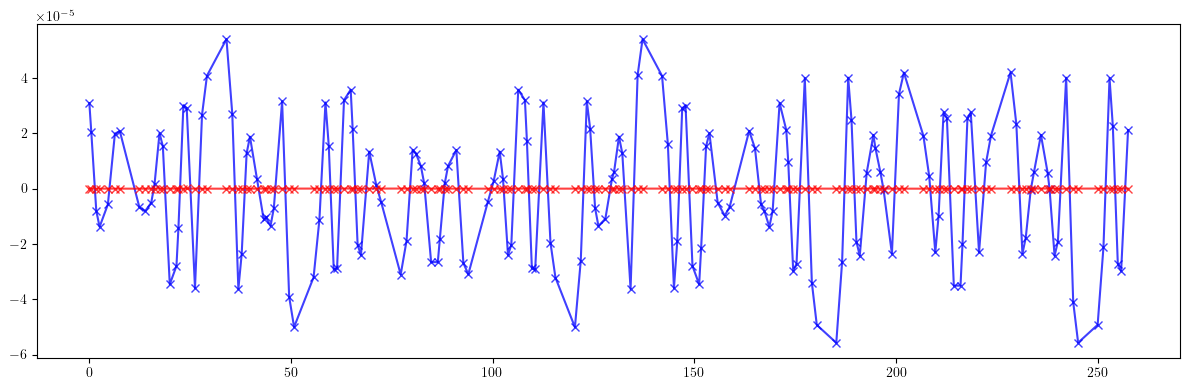

In [24]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

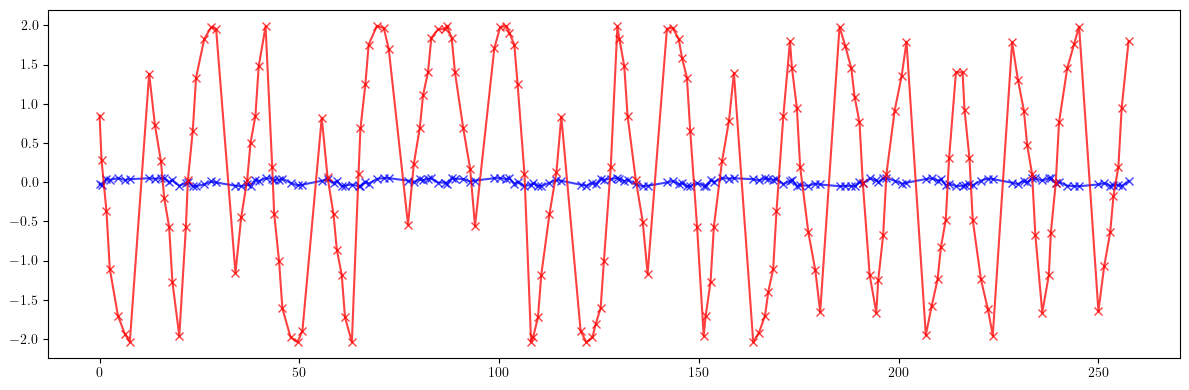

tensor(0.0365, dtype=torch.float64)
tensor(1.3367, dtype=torch.float64)


In [25]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

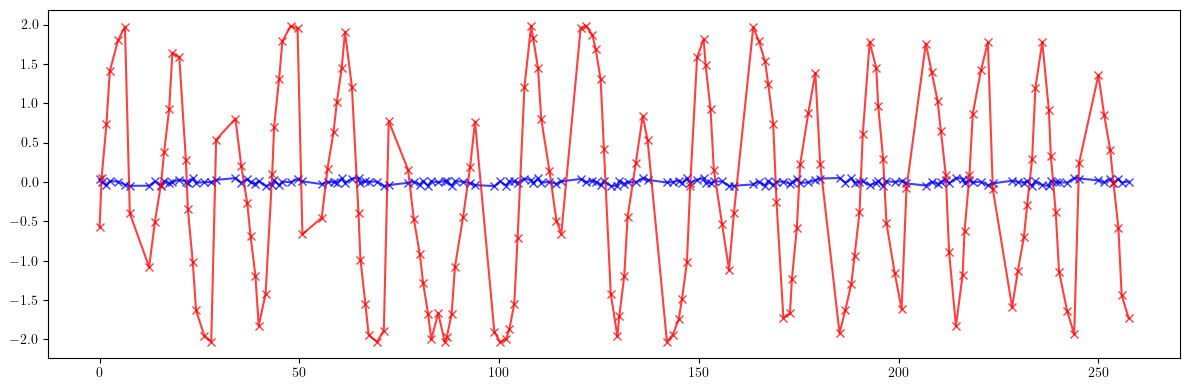

tensor(0.0280, dtype=torch.float64)
tensor(1.2673, dtype=torch.float64)


In [26]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

In [27]:
# Define parametric observable vector

def observable_tune(knobs):
    kf, kd, ko = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd] + len(QO)*[ko])
    return tune(error, [kn], ('kn', None, QF + QD + QO, None), matched=True, limit=1)

def observable_orm(knobs):
    kf, kd, ko = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd] + len(QO)*[ko])
    return ORM(error, orbit,  [kn], ('kn', None, QF + QD + QO, None), limit=1).flatten()

def observable_twiss(knobs):
    kf, kd, ko = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd] + len(QO)*[ko])
    _, bx, _, by = twiss(error, [kn], ('kn', None, QF + QD + QO, None), matched=True, advance=True, full=False, convert=True).T
    return torch.stack([bx, by]).T.flatten()

In [28]:
# Check the residual vector norm

knobs = torch.tensor(3*[0.0], dtype=dtype)

print(((observable_tune(knobs) - target_tune)**2).sum())
print(((observable_orm(knobs) - target_orm)**2).sum())
print(((observable_twiss(knobs) - target_twiss)**2).sum())

tensor(7.8937e-06, dtype=torch.float64)
tensor(60.5301, dtype=torch.float64)
tensor(2.3121, dtype=torch.float64)


In [29]:
# Optimization loop

matrix = matrix_orm
target = target_orm
observable = observable_orm

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-6
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.25

# Initial value

knobs = torch.tensor(3*[0.0], dtype=dtype)

# Correction loop

for _ in range(8):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(60.5301, dtype=torch.float64)
tensor(49.8188, dtype=torch.float64)
tensor(43.7347, dtype=torch.float64)
tensor(40.3159, dtype=torch.float64)
tensor(38.4178, dtype=torch.float64)
tensor(37.3796, dtype=torch.float64)
tensor(36.8229, dtype=torch.float64)
tensor(36.5327, dtype=torch.float64)



In [30]:
# Apply final corrections

kd, kf, ko = knobs

error.flatten()

for name in QF:
    error[name].kn = (error[name].kn + kd).item()

for name in QD:
    error[name].kn = (error[name].kn + kf).item()

for name in QO:
    error[name].kn = (error[name].kn + ko).item()
    
error.splice()

In [31]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(error, [], matched=True, limit=1)

In [32]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [33]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [34]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [35]:
# Compute coupling

c_result = coupling(error, [])

In [36]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(7.9195e-05, dtype=torch.float64)
tensor(0.0028, dtype=torch.float64)

tensor(0.0001, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)



In [37]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(6.5965e-08, dtype=torch.float64)
tensor(6.5786e-08, dtype=torch.float64)


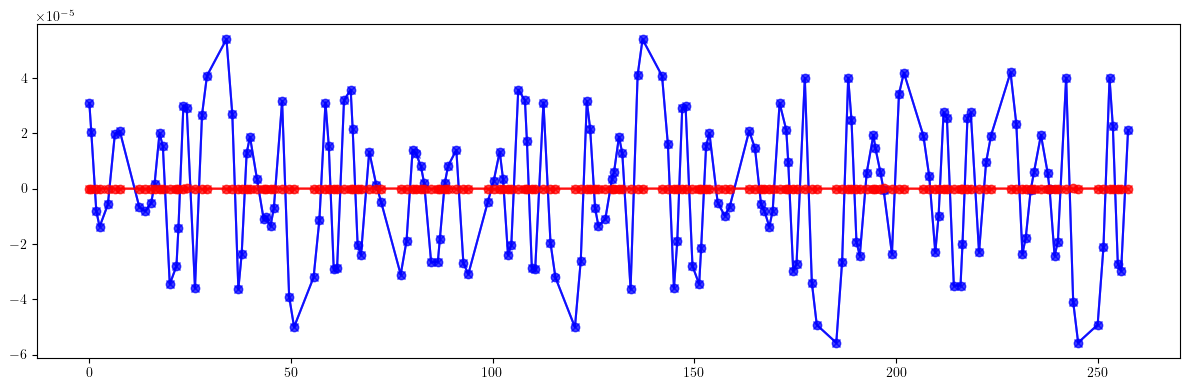

In [38]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

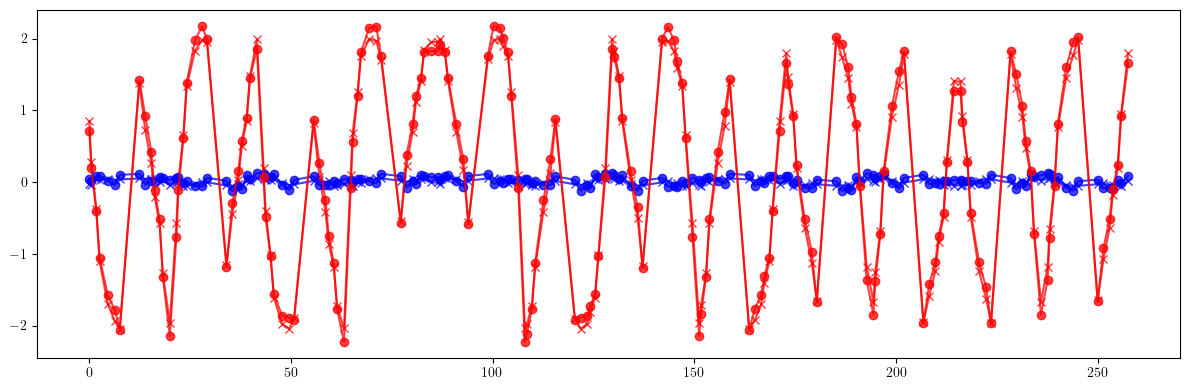

tensor(0.0365, dtype=torch.float64)
tensor(1.3367, dtype=torch.float64)

tensor(0.0683, dtype=torch.float64)
tensor(1.3570, dtype=torch.float64)



In [39]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

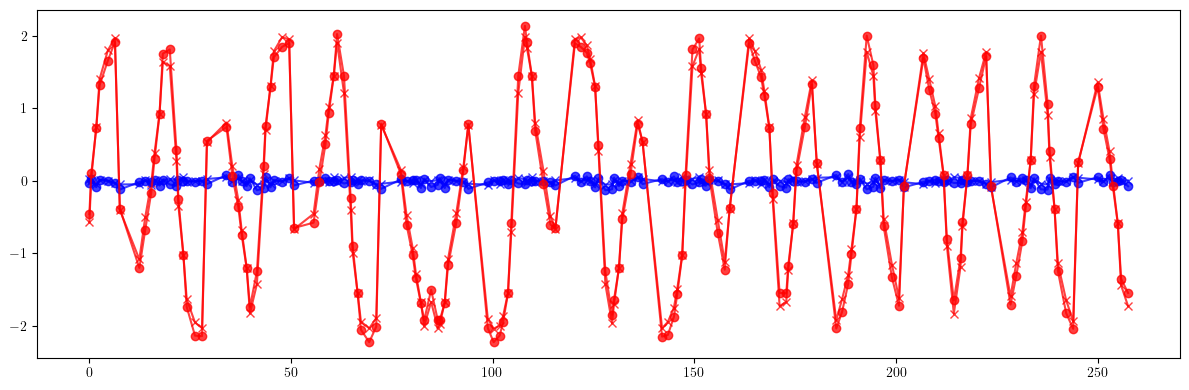

tensor(0.0280, dtype=torch.float64)
tensor(1.2673, dtype=torch.float64)

tensor(0.0502, dtype=torch.float64)
tensor(1.2869, dtype=torch.float64)



In [40]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_result)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_result)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())
print()

print(100*(((mux - mux_result)/mux)**2).mean().sqrt())
print(100*(((muy - muy_result)/muy)**2).mean().sqrt())
print()

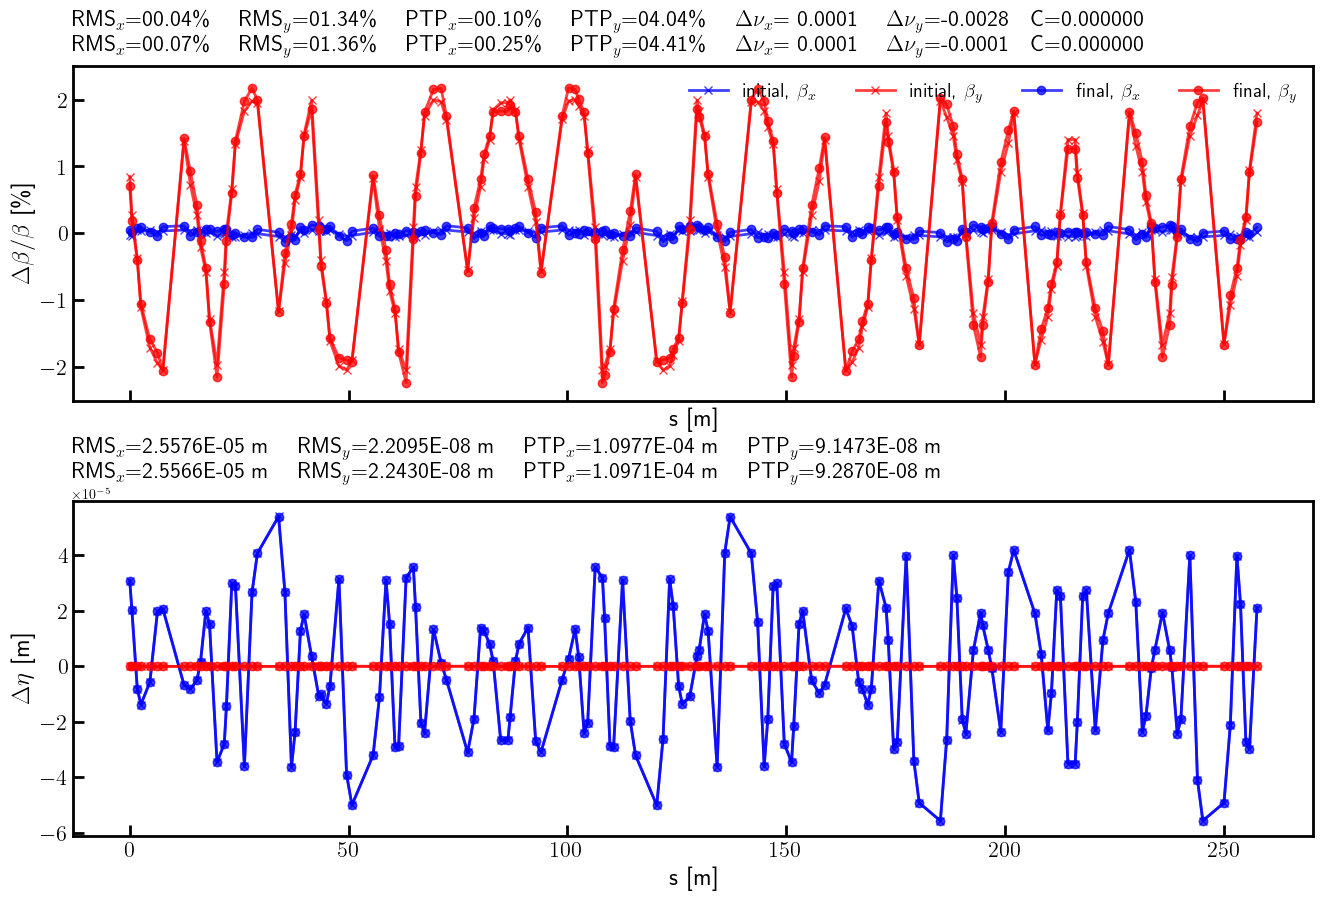

In [41]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_id)    / bx
by_ref_bb = 100.0*(by - by_id)    / by
bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_ref = etaqx - etaqx_id
etay_ref = etaqy - etaqy_id
etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()
etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'initial, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_id)}{(nux - nux_id).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_id)}{(nuy - nuy_id).abs().item():.4f}'
    rf'\quad C={c_id.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-2.5, 2.5)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'initial, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()